# UFC Chapter - Saturn Prototype

## Dependency Center

In [1]:
# Import General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Import scikit-learn Utilities and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    mean_squared_error
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

# Import Modeling Tools
from sklearn.svm import SVC
import xgboost as xgb

# Import Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Data Loading and Cleansing

In [2]:
# Load the data from the source
url = 'https://www.kaggle.com/mdabbert/ultimate-ufc-dataset?select=ufc-master.csv'
data = pd.read_csv('Data/ufc-master.csv')

# Create a DataFrame
ufcdata = pd.DataFrame(data)

# Display basic information
print(f"The shape of the DataFrame is {ufcdata.shape}")
print(f"Columns in the DataFrame: {ufcdata.columns}")

# Show an example row of the df to better understand the data.
pd.set_option('display.max_columns', None)

# Since this is a very large dataset, there are many NaN values for some of the columns as they don't apply to a each fight.
# In this case, there are columns for the official UFC rankings, but each fight only takes place in 1 division, where only 15 fighters are ranked.
# Thus, there are many categorical columns that could just be represented by 0.

# In order to fix this issue, we use the .fillna function to fill empty values with a 0.
ufcdata.fillna(0, inplace=True)


The shape of the DataFrame is (4896, 119)
Columns in the DataFrame: Index(['R_fighter', 'B_fighter', 'R_odds', 'B_odds', 'R_ev', 'B_ev', 'date',
       'location', 'country', 'Winner',
       ...
       'finish_details', 'finish_round', 'finish_round_time',
       'total_fight_time_secs', 'r_dec_odds', 'b_dec_odds', 'r_sub_odds',
       'b_sub_odds', 'r_ko_odds', 'b_ko_odds'],
      dtype='object', length=119)


In [3]:
# Next, to further clean the data, we remove the columns at the end of the df because they are only filled out for about half the fights.
# The columns we want to remove begin with "better_rank" and end at the last column of the df.
# This is a seperate issue from the NaN issue becuase filling these columns with 0 would lead to summation errors.

# Drop columns starting from 'better_rank' to the end
columns_to_drop = ufcdata.columns[ufcdata.columns.get_loc("better_rank"):]
ufcdata.drop(columns=columns_to_drop, inplace=True)

# Display dataframe portion
display(ufcdata.head())


,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Light Heavyweight,MALE,5,0,1,0,3.42,0.59,0.7,0.24,1.00,4,2,11,0,0,0,1,4,0,0,5,Orthodox,198.12,208.28,205,3,0,0,3.95,0.48,0.1,0.61,0.36,4,8,43,1,0,0,2,11,0,0,13,Orthodox,187.96,193.04,205,37,29,-3,1,0,-8,-6,-32,-1,-7,0,10.16,15.24,-8,-0.53,0.6,-0.37,1,1,10.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,2,0,0,5.16,0.42,0.8,0.79,0.22,2,5,24,0,0,0,0,4,2,0,6,Orthodox,182.88,193.04,170,2,0,0,2.97,0.51,0.5,2.27,0.37,4,8,44,0,0,1,3,4,3,0,11,Orthodox,180.34,193.04,170,33,32,0,0,-2,-5,-3,-20,0,0,-1,2.54,0.00,-1,2.19,0.3,-1.48,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,1,0,0,2.92,0.41,0.1,1.15,0.34,5,5,38,0,0,2,6,1,0,0,9,Southpaw,185.42,195.58,185,1,0,0,3.77,0.49,1.7,4.48,0.44,4,4,13,0,0,0,0,1,5,0,6,Orthodox,190.50,195.58,205,34,32,0,0,1,3,1,25,0,0,-5,-5.08,0.00,-2,-0.85,-1.6,-3.33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Lightweight,MALE,3,1,0,0,4.04,0.34,0.0,0.00,0.00,0,1,3,0,0,0,0,0,0,0,0,Orthodox,177.80,177.80,155,1,0,0,3.79,0.36,0.0,1.57,0.35,2,3,15,0,0,0,2,2,0,0,4,Orthodox,175.26,182.88,155,29,32,0,0,-2,-4,-2,-12,0,-2,0,2.54,-5.08,3,0.25,0.0,-1.57,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Lightweight,MALE,3,0,2,0,5.22,0.56,0.0,2.54,0.39,2,3,19,0,0,0,4,1,0,0,5,Orthodox,175.26,172.72,145,0,4,0,2.64,0.62,0.6,2.85,0.52,4,0,8,0,0,0,2,0,2,0,4,Orthodox,175.26,177.80,155,28,33,0,-2,-2,1,3,11,0,1,-2,0.00,-5.08,5,2.58

In [4]:
# Now our data is cleaned and ready for our analysis questions! 
# One-hot encoding for categorical variables.
# Map categorical variables to numerical values
GenderMap = {'MALE': 1, 'FEMALE': 2}
StanceMap = {'Orthodox': 1, 'Southpaw': 2}

ufcdata['gender'] = ufcdata['gender'].map(GenderMap)
ufcdata['B_Stance'] = ufcdata['B_Stance'].map(StanceMap)
ufcdata['R_Stance'] = ufcdata['R_Stance'].map(StanceMap)

# Null injections
ufcdata = ufcdata.fillna(0)

# Display dataframe portion
display(ufcdata.head())

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Light Heavyweight,1,5,0,1,0,3.42,0.59,0.7,0.24,1.00,4,2,11,0,0,0,1,4,0,0,5,1.0,198.12,208.28,205,3,0,0,3.95,0.48,0.1,0.61,0.36,4,8,43,1,0,0,2,11,0,0,13,1.0,187.96,193.04,205,37,29,-3,1,0,-8,-6,-32,-1,-7,0,10.16,15.24,-8,-0.53,0.6,-0.37,1,1,10.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,1,3,2,0,0,5.16,0.42,0.8,0.79,0.22,2,5,24,0,0,0,0,4,2,0,6,1.0,182.88,193.04,170,2,0,0,2.97,0.51,0.5,2.27,0.37,4,8,44,0,0,1,3,4,3,0,11,1.0,180.34,193.04,170,33,32,0,0,-2,-5,-3,-20,0,0,-1,2.54,0.00,-1,2.19,0.3,-1.48,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,1,3,1,0,0,2.92,0.41,0.1,1.15,0.34,5,5,38,0,0,2,6,1,0,0,9,2.0,185.42,195.58,185,1,0,0,3.77,0.49,1.7,4.48,0.44,4,4,13,0,0,0,0,1,5,0,6,1.0,190.50,195.58,205,34,32,0,0,1,3,1,25,0,0,-5,-5.08,0.00,-2,-0.85,-1.6,-3.33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Lightweight,1,3,1,0,0,4.04,0.34,0.0,0.00,0.00,0,1,3,0,0,0,0,0,0,0,0,1.0,177.80,177.80,155,1,0,0,3.79,0.36,0.0,1.57,0.35,2,3,15,0,0,0,2,2,0,0,4,1.0,175.26,182.88,155,29,32,0,0,-2,-4,-2,-12,0,-2,0,2.54,-5.08,3,0.25,0.0,-1.57,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Lightweight,1,3,0,2,0,5.22,0.56,0.0,2.54,0.39,2,3,19,0,0,0,4,1,0,0,5,1.0,175.26,172.72,145,0,4,0,2.64,0.62,0.6,2.85,0.52,4,0,8,0,0,0,2,0,2,0,4,1.0,175.26,177.80,155,28,33,0,-2,-2,1,3,11,0,1,-2,0.00,-5.08,5,2.58,-0.6,-0.31,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [5]:
# Create binary columns for 'Red Winner' and 'Blue Winner'
ufcdata['Red Winner'] = (ufcdata['Winner'] == 'Red').astype(int)
ufcdata['Blue Winner'] = (ufcdata['Winner'] == 'Blue').astype(int)

# Drop the original 'Winner' column
ufcdata.drop(columns=['Winner'], inplace=True)

# Display the updated DataFrame
display(ufcdata.head())


,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,Red Winner,Blue Winner
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,False,Light Heavyweight,1,5,0,1,0,3.42,0.59,0.7,0.24,1.00,4,2,11,0,0,0,1,4,0,0,5,1.0,198.12,208.28,205,3,0,0,3.95,0.48,0.1,0.61,0.36,4,8,43,1,0,0,2,11,0,0,13,1.0,187.96,193.04,205,37,29,-3,1,0,-8,-6,-32,-1,-7,0,10.16,15.24,-8,-0.53,0.6,-0.37,1,1,10.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,False,Welterweight,1,3,2,0,0,5.16,0.42,0.8,0.79,0.22,2,5,24,0,0,0,0,4,2,0,6,1.0,182.88,193.04,170,2,0,0,2.97,0.51,0.5,2.27,0.37,4,8,44,0,0,1,3,4,3,0,11,1.0,180.34,193.04,170,33,32,0,0,-2,-5,-3,-20,0,0,-1,2.54,0.00,-1,2.19,0.3,-1.48,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,False,Middleweight,1,3,1,0,0,2.92,0.41,0.1,1.15,0.34,5,5,38,0,0,2,6,1,0,0,9,2.0,185.42,195.58,185,1,0,0,3.77,0.49,1.7,4.48,0.44,4,4,13,0,0,0,0,1,5,0,6,1.0,190.50,195.58,205,34,32,0,0,1,3,1,25,0,0,-5,-5.08,0.00,-2,-0.85,-1.6,-3.33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,False,Lightweight,1,3,1,0,0,4.04,0.34,0.0,0.00,0.00,0,1,3,0,0,0,0,0,0,0,0,1.0,177.80,177.80,155,1,0,0,3.79,0.36,0.0,1.57,0.35,2,3,15,0,0,0,2,2,0,0,4,1.0,175.26,182.88,155,29,32,0,0,-2,-4,-2,-12,0,-2,0,2.54,-5.08,3,0.25,0.0,-1.57,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,False,Lightweight,1,3,0,2,0,5.22,0.56,0.0,2.54,0.39,2,3,19,0,0,0,4,1,0,0,5,1.0,175.26,172.72,145,0,4,0,2.64,0.62,0.6,2.85,0.52,4,0,8,0,0,0,2,0,2,0,4,1.0,175.26,177.80,155,28,33,0,-2,-2,1,3,11,0,1,-2,0.00,-5.08,5,2.58,-0.6,-0.31,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

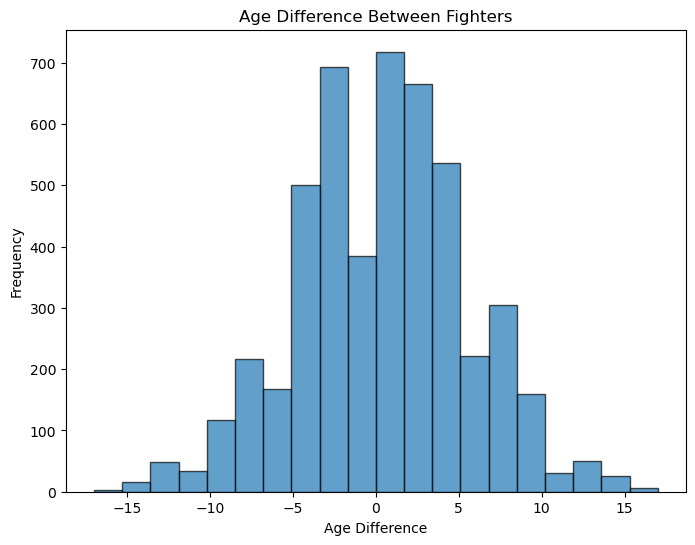

In [6]:
# Create a histogram for the 'age_dif' column
plt.figure(figsize=(8, 6))
plt.hist(ufcdata['age_dif'], bins=20, edgecolor='k', alpha=0.7)

# Customize the plot
plt.title('Age Difference Between Fighters')
plt.xlabel('Age Difference')
plt.ylabel('Frequency')

# Show the plot
plt.show()

#This histogram shows the age difference between fighters. 
#The majority of fights have an age difference of 0, 
#meaning the fighters are the same age more often than not


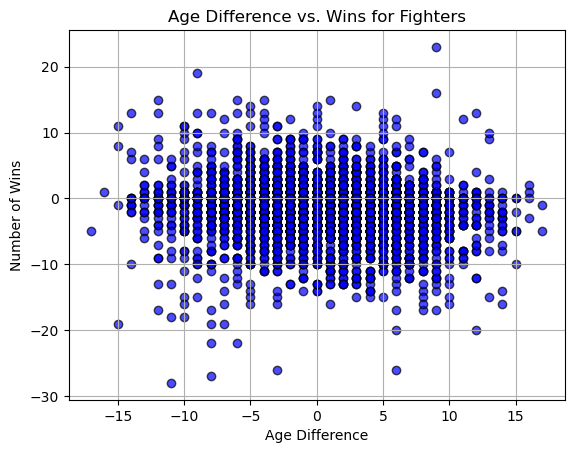

In [7]:
# Each point on the plot represents a fighter, allowing you to visually assess if there's any 
# relationship between age difference and wins in your UFC dataset.
#The outliers on each end show that wins tend to increase or decrease when there is a huge age gap between fighters.
# Create a scatter plot for age vs. wins
plt.scatter(ufcdata['age_dif'], ufcdata['win_dif'], c='blue', marker='o', edgecolors='k', alpha=0.7)

# Customize the plot
plt.title('Age Difference vs. Wins for Fighters')
plt.xlabel('Age Difference')
plt.ylabel('Number of Wins')

# Show the plot
plt.grid(True)
plt.show()


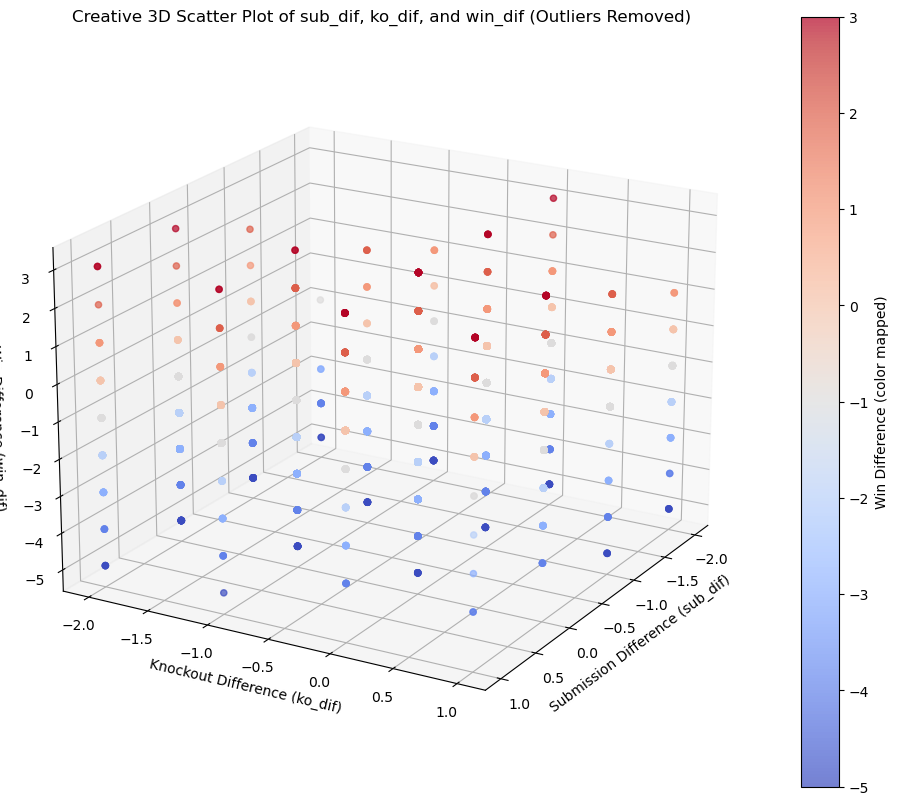

In [8]:
# Function to remove outliers based on IQR
def remove_outliers(data, column):
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Filter out outliers for 'sub_dif', 'ko_dif', and 'win_dif'
filtered_data = ufcdata.copy()
filtered_data = remove_outliers(filtered_data, 'sub_dif')
filtered_data = remove_outliers(filtered_data, 'ko_dif')
filtered_data = remove_outliers(filtered_data, 'win_dif')

# Create a 3D scatter plot for the filtered data
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Use the filtered data for sub_dif, ko_dif, and win_dif
sub_dif = filtered_data['sub_dif']
ko_dif = filtered_data['ko_dif']
win_dif = filtered_data['win_dif']

# Create the 3D scatter plot with color mapping based on win_dif
scatter = ax.scatter(sub_dif, ko_dif, win_dif, c=win_dif, cmap='coolwarm', marker='o', alpha=0.7)

# Customize the plot
ax.set_xlabel('Submission Difference (sub_dif)')
ax.set_ylabel('Knockout Difference (ko_dif)')
ax.set_zlabel('Win Difference (win_dif)')
ax.set_title('Creative 3D Scatter Plot of sub_dif, ko_dif, and win_dif (Outliers Removed)')
ax.grid(True, linestyle='--', alpha=0.5)

# Add a color bar to indicate win_dif values
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Win Difference (color mapped)')

# Adjust the view angle for better visualization
ax.view_init(elev=20, azim=30)  # You can experiment with different angles

# Show the plot
plt.show()



#This 3d scatter plot shows the relationship between the three variables
#The majority of the data is clustered around the origin, meaning that most fights have a similar number of knockouts, submissions, and wins because fighters specialize in different areas.
#This is best viewed in jupyter notebook, as the plot is interactive and can be rotated to view from different angles.

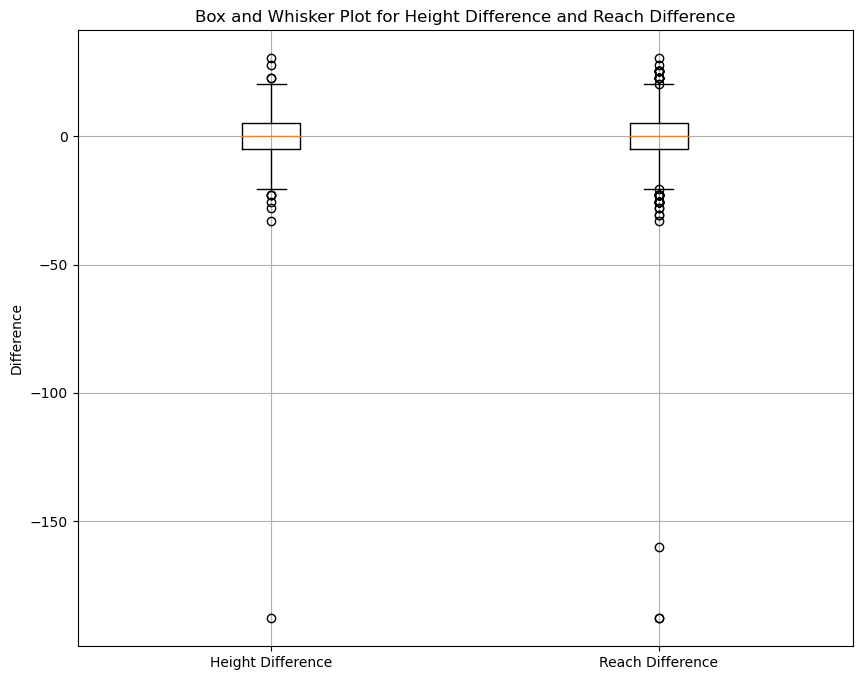

In [9]:
# Create a box and whisker plot for height_dif and reach_dif
plt.figure(figsize=(10, 8))
plt.boxplot([ufcdata['height_dif'], ufcdata['reach_dif']], labels=['Height Difference', 'Reach Difference'])

# Customize the plot
plt.title('Box and Whisker Plot for Height Difference and Reach Difference')
plt.ylabel('Difference')
plt.grid(True)

# Show the plot
plt.show()

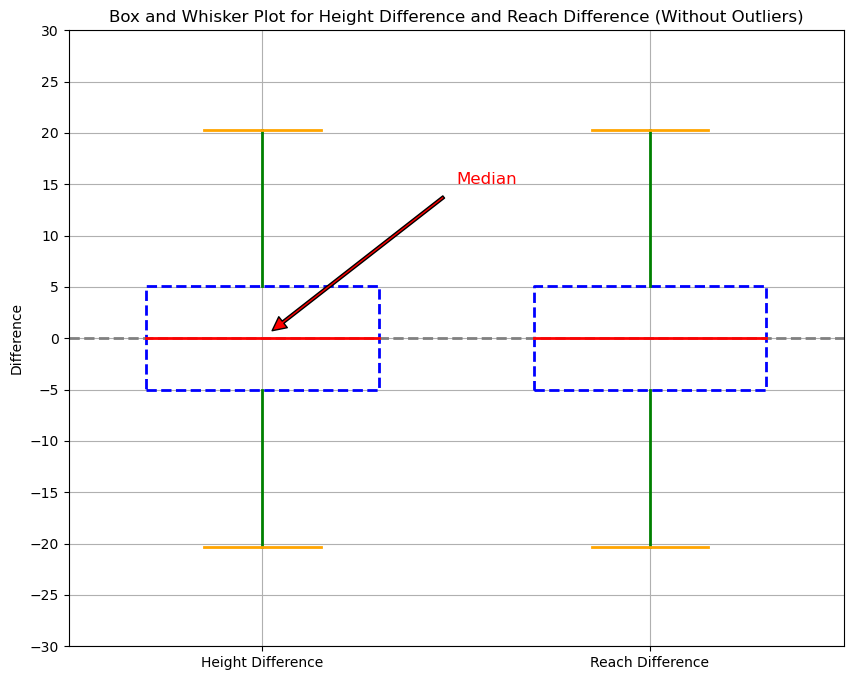

In [10]:
# Create a box and whisker plot without outliers for height_dif and reach_dif
plt.figure(figsize=(10, 8))

# Custom boxplot styles
boxprops = dict(linestyle='--', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=2, color='red')
whiskerprops = dict(linestyle='-', linewidth=2, color='green')
capprops = dict(linestyle='-', linewidth=2, color='orange')

# Create the box and whisker plot
plt.boxplot([ufcdata['height_dif'], ufcdata['reach_dif']], labels=['Height Difference', 'Reach Difference'], widths=0.6, showfliers=False,
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

# Customize the y-axis ticks
yticks = np.arange(-30, 31, 5)
plt.yticks(yticks)

# Customize the plot
plt.title('Box and Whisker Plot for Height Difference and Reach Difference (Without Outliers)')
plt.ylabel('Difference')
plt.grid(True)

# Add some creativity, e.g., annotation or background color
plt.annotate('Median', xy=(1, ufcdata['reach_dif'].median()), xytext=(1.5, 15),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10, headlength=10),
             fontsize=12, color='red')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# Show the plot
plt.show()

## Machine Learning Model Workshops

In [11]:
# To avoid overfitting, we will only focus on the Odds, Gender, then the differnces between the fighters in each category.

# Select relevant columns
columns = [
    'R_odds', 'gender', 'lose_streak_dif', 'win_streak_dif',
    'longest_win_streak_dif', 'win_dif', 'loss_dif', 'total_round_dif',
    'ko_dif', 'sub_dif', 'height_dif', 'reach_dif', 'age_dif',
    'avg_sub_att_dif', 'avg_td_dif'
]

X = ufcdata[columns]
y = ufcdata["Red Winner"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=50
)


### XGBoost Model

In [12]:
# Train, Test, Eval: XGBoost Model
# Define parameter grid for GridSearch
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier and perform GridSearch for hyperparameter tuning
xgb_clf = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters from the Grid Search
best_params = grid_search.best_params_

# Train the classifier with the best parameters and make predictions
xgb_clf_best = xgb.XGBClassifier(objective='binary:logistic', **best_params)
xgb_clf_best.fit(X_train, y_train)
y_pred = xgb_clf_best.predict(X_test)

# Evaluate the model
accuracy_xg = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f'Optimized XGBoost Model Metrics:')
print(f'Accuracy: {accuracy_xg}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Optimized XGBoost Model Metrics:
Accuracy: 0.6528250510551395
Precision: 0.6468183074190802
Recall: 0.6528250510551395
F1 Score: 0.6457786138922916


### Support Vector Machine Model

In [13]:
# Train, Test, Eval: Support Vector Machine Model
# Define a more simplified parameter grid for GridSearch
param_grid_svm = {
    'C': [0.1, 1],  # Reduced to only two options
    'kernel': ['linear'],  # Use only 'linear' as it's generally faster than 'rbf' or 'poly'
}

# Initialize SVM classifier and perform GridSearch for hyperparameter tuning
# Optionally, use a random subset of the data to speed up GridSearch
svm_clf = SVC()
grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, cv=2, scoring='accuracy')  # Kept CV at 2
grid_search_svm.fit(X_train.sample(frac=0.5, random_state=42), y_train.sample(frac=0.5, random_state=42))  # Using 50% of the data

# Get the best parameters from the Grid Search
best_params_svm = grid_search_svm.best_params_

# Train the classifier with the best parameters and make predictions
svm_clf_best = SVC(**best_params_svm)
svm_clf_best.fit(X_train, y_train)  # Using full data for final training
y_pred_svm = svm_clf_best.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Print evaluation metrics
print(f'Optimized SVM Model Metrics:')
print(f'Accuracy: {accuracy_svm}')
print(f'Precision: {precision_svm}')
print(f'Recall: {recall_svm}')
print(f'F1 Score: {f1_svm}')


Optimized SVM Model Metrics:
Accuracy: 0.6596324029952348
Precision: 0.6538446732428276
Recall: 0.6596324029952348
F1 Score: 0.651708714286105


### Random Forest Model

In [14]:
# Train, Test, Eval: Random Forest Classifier Model
model_rf = RandomForestClassifier(n_estimators=100, max_features=7, random_state=42, min_samples_leaf=5, max_depth=5)
model_rf.fit(X_train, y_train)
predict_rf = model_rf.predict(X_test)
acc_rf = accuracy_score(y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')


Random Forest Accuracy: 0.6541865214431586


In [15]:
# Train, Test, Eval: AdaBoost Classifier Model
base_est = DecisionTreeClassifier(max_depth=4)
ada = AdaBoostClassifier(estimator=base_est)

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [3, 5]
}

grid_search = GridSearchCV(ada, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_ada = grid_search.best_estimator_
best_ada.fit(X_train, y_train)
predict_ada = best_ada.predict(X_test)

acc_ada = accuracy_score(y_test, predict_ada)
print(f'Ada Boost Accuracy: {acc_ada}')

# Additional metrics for AdaBoost
precision_ada = precision_score(y_test, predict_ada, average='weighted')
recall_ada = recall_score(y_test, predict_ada, average='weighted')
f1_ada = f1_score(y_test, predict_ada, average='weighted')

print(f'Precision: {precision_ada}')
print(f'Recall: {recall_ada}')
print(f'F1 Score: {f1_ada}')


Ada Boost Accuracy: 0.6501021102791015
Precision: 0.6441005481430112
Recall: 0.6501021102791015
F1 Score: 0.6434999903836425


In [16]:
# Train, Test, Eval: Dummy Classifier Model
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f'Dummy Classifier Accuracy: {accuracy_dummy}')


Dummy Classifier Accuracy: 0.584070796460177


In [17]:
# Train, Test, Eval: Decision Tree Classifier Model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')


Decision Tree Accuracy: 0.585432266848196


In [18]:
# Train, Test, Eval: Keras Model
# Convert labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# One-hot encode labels
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Create a Keras model
keras_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train_one_hot.shape[1], activation='softmax')
])

# Compile the model (notice the change from 'lr' to 'learning_rate')
keras_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = keras_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = keras_model.evaluate(X_test, y_test_one_hot)
print(f'Keras Model Accuracy: {accuracy}')

# Additional Evaluation Metrics
y_pred_one_hot = keras_model.predict(X_test)
y_pred_encoded = np.argmax(y_pred_one_hot, axis=1)

precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted')
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 1.7277 - accuracy: 0.5691 - val_loss: 0.6473 - val_accuracy: 0.6414
Epoch 2/50
86/86 [==============================] - 0s 1ms/step - loss: 0.9786 - accuracy: 0.5852 - val_loss: 0.7168 - val_accuracy: 0.6691
Epoch 3/50
86/86 [==============================] - 0s 1ms/step - loss: 0.8341 - accuracy: 0.6012 - val_loss: 0.7004 - val_accuracy: 0.5612
Epoch 4/50
46/46 [==============================] - 0s 579us/step - loss: 0.6932 - accuracy: 0.6392
Keras Model Accuracy: 0.6392103433609009
46/46 [==============================] - 0s 513us/step
Precision: 0.6393812393050363
Recall: 0.639210347174949
F1 Score: 0.6392946142497712


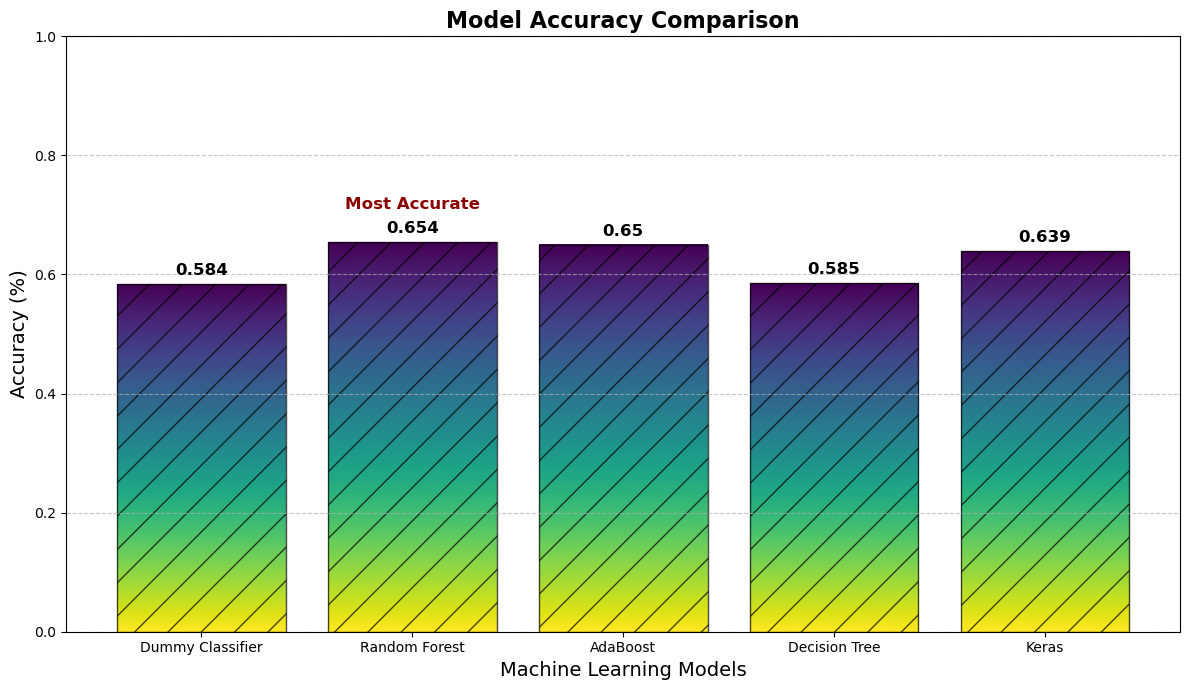

In [19]:
# Model Accuracy Comparison
models = ["Dummy Classifier", "Random Forest", "AdaBoost", "Decision Tree", "Keras"]
accuracies = [accuracy_dummy, acc_rf, acc_ada, accuracy_dt, accuracy]
max_index = accuracies.index(max(accuracies))

def gradientbars(bars):
    grad = np.atleast_2d(np.linspace(0, 1, 256)).T
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0)
    ax.axis(lim)

plt.figure(figsize=(12, 7))

# Define a custom color palette (blues, greens, and yellows)
custom_colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Bar borders and hatching pattern for all bars
bars = plt.bar(models, accuracies, edgecolor='black', hatch='/', alpha=0.7, color=custom_colors)

# Apply gradient to bars
gradientbars(bars)

# Add title and labels
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Machine Learning Models', fontsize=14, color='black')  # Set axis label color to black
plt.ylabel('Accuracy (%)', fontsize=14, color='black')  # Set axis label color to black
plt.ylim(0, 1)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # If this bar represents the Random Forest model (highest accuracy), annotate it
    if idx == max_index:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, 'Most Accurate', ha='center', va='bottom', fontweight='bold', color='darkred', fontsize=12)

# Show the chart
plt.tight_layout()
plt.show()

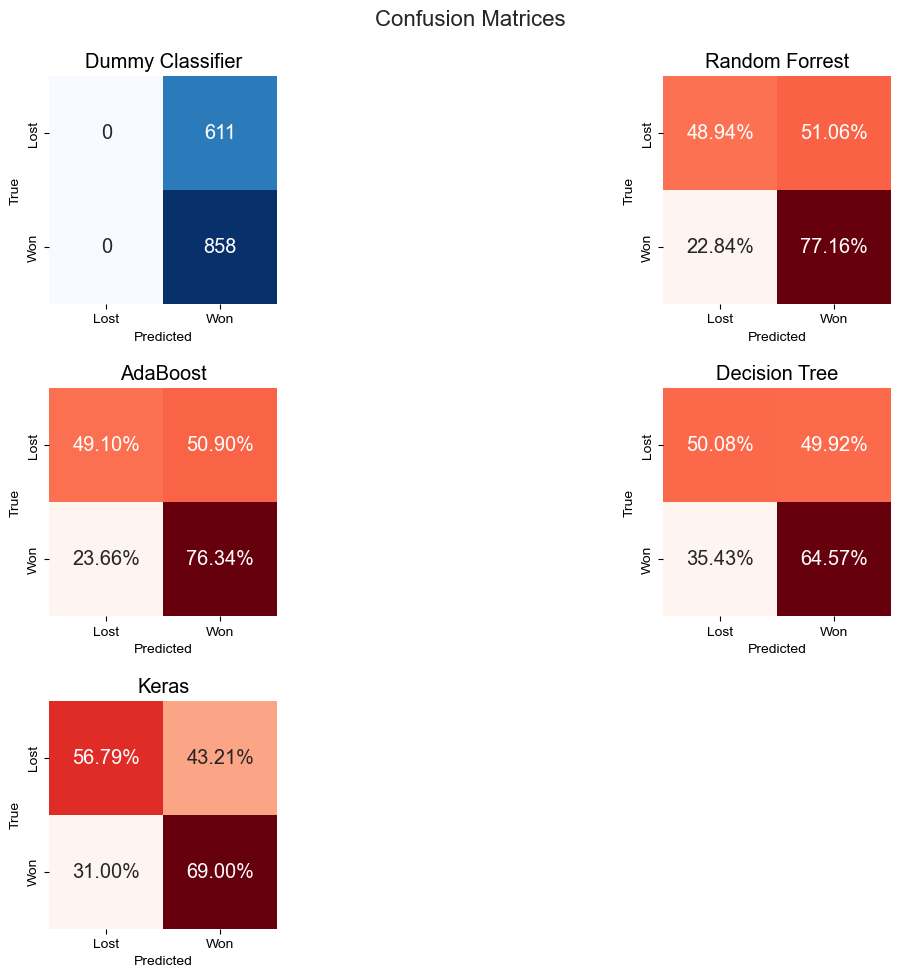

In [20]:
# Confusion Matrices

import seaborn as sns

# import confusion_matrix
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["Lost", "Won"]

# Define the list of models and their predictions
models = ["Dummy Classifier", "Random Forrest", "AdaBoost", "Decision Tree", "Keras"]
model_predictions = [
    y_pred_dummy,  # Dummy Classifier predictions
    predict_rf,  # Random Forest predictions
    predict_ada,  # AdaBoost predictions
    y_pred_dt,  # Decision Tree predictions
    y_pred_encoded  # Keras predictions
   
   ]

# Create a grid of subplots based on the number of models
num_models = len(models)
cols = 2  # Number of columns in the grid
rows = -(-num_models // cols)  # Calculate the number of rows needed

# Set up the subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5)
sns.set(font_scale=1.2)  # Adjust the font size

# Create a header at the very top
fig.suptitle('Confusion Matrices', fontsize=16)

for idx, (model_name, y_pred) in enumerate(zip(models, model_predictions)):
    ax = axes[idx // cols, idx % cols]

    y_true = y_test

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Check if it's the Dummy Classifier
    if model_name == "Dummy Classifier":
        # Plot the confusion matrix with actual values
        cmap = sns.color_palette("Blues", as_cmap=True)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=False, square=True,
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    else:
        # Normalize the confusion matrix to show percentages
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        # Plot the confusion matrix with shades of red
        cmap = sns.color_palette("Reds", as_cmap=True)
        sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap=cmap, cbar=False, square=True,
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(model_name)

# Remove empty subplots
for idx in range(len(models), rows * cols):
    fig.delaxes(axes[idx // cols, idx % cols])

plt.tight_layout()
plt.show()

# These figures measure recall. If, say, you have a confusion matrix cell where the true class is "lost" and the predicted 
# class is also "lost," and it shows a value of 56.63%, it means that the model correctly predicted instances where the 
# true class was "lost" 56.63% of the time out of all instances where the true class was "lost." In other words, it represents
# the recall (true positive rate) for the "lost" class.

# The DummyClassifier's strategy is to predict the majority class, and in this case, the majority class in the testing data is
# "won," leading to 100% accuracy for true (won) / predicted (won) and true (lost) / predicted (won) cells. The DummyClassifier's
#  performance is hence quite limited and doesn't provide meaningful insights, but it serves as a baseline to compare against when 
# evaluating more advanced models. This is why the DummyClassifier cells are expressed in absolute values.

c:\Users\Bama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Bama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Bama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


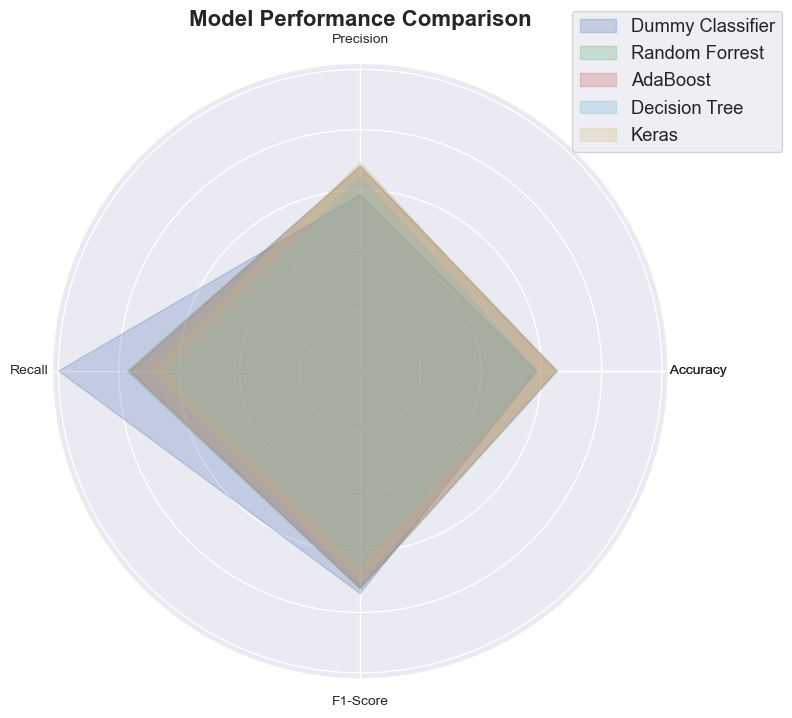

In [21]:
# Model Performance Comparison

from sklearn.metrics import classification_report

# Define the models and their predictions
models = ["Dummy Classifier", "Random Forrest", "AdaBoost", "Decision Tree", "Keras"]
model_predictions = [
    y_pred_dummy,  # Dummy Classifier predictions
    predict_rf,  # Random Forest predictions
    predict_ada,  # AdaBoost predictions
    y_pred_dt,  # Decision Tree predictions
    y_pred_encoded  # Keras predictions
   
   ]

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

# Set the y-axis labels
ax.set_yticklabels([])

# Define performance metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Initialize lists to store metric scores for each model
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Calculate and store metric scores for each model
for y_pred in model_predictions:
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    accuracy_scores.append(report["accuracy"])
    precision_scores.append(report[class_labels[1]]["precision"])
    recall_scores.append(report[class_labels[1]]["recall"])
    f1_scores.append(report[class_labels[1]]["f1-score"])

# Define the colors for the radar chart
colors = ['b', 'g', 'r', 'c','y']

# Define the number of metrics
num_metrics = len(metrics)

# Calculate the angles for each metric
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the plot

# Plot the data for each model
for i in range(len(models)):
    values = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    values += values[:1]  # Close the plot

    ax.fill(angles, values, alpha=0.25, label=models[i], color=colors[i])
    ax.set_xticks(angles)
    ax.set_xticklabels(["", metrics[1], "Recall", metrics[3], "    Accuracy"])  # Adjust label positions
    ax.tick_params(axis='x', labelsize=10)  # Adjust font size

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Add a title
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')

# Show the radar chart
plt.show()

# Accuracy is a measure of the overall correctness of a classification model.
# It is the ratio of correctly predicted instances (both true positives and true negatives) to the total number of instances in 
# the dataset.
# Formula: (True Positives + True Negatives) / Total Instances

# Precision measures the accuracy of positive predictions made by the model.
# It is the ratio of true positives to the total number of positive predictions (true positives + false positives).
# Precision focuses on minimizing false positive errors.
# Formula: True Positives / (True Positives + False Positives)

# Recall measures the ability of the model to correctly identify positive instances.
# It is the ratio of true positives to the total number of actual positive instances (true positives + false negatives).
# Recall focuses on minimizing false negative errors.
# Formula: True Positives / (True Positives + False Negatives)

# The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall.
# It is particularly useful when you want to find an optimal balance between minimizing false positives and false negatives.
# Formula: 2 * (Precision * Recall) / (Precision + Recall)

# See above for the low utility of plotting DummyClassifier results.

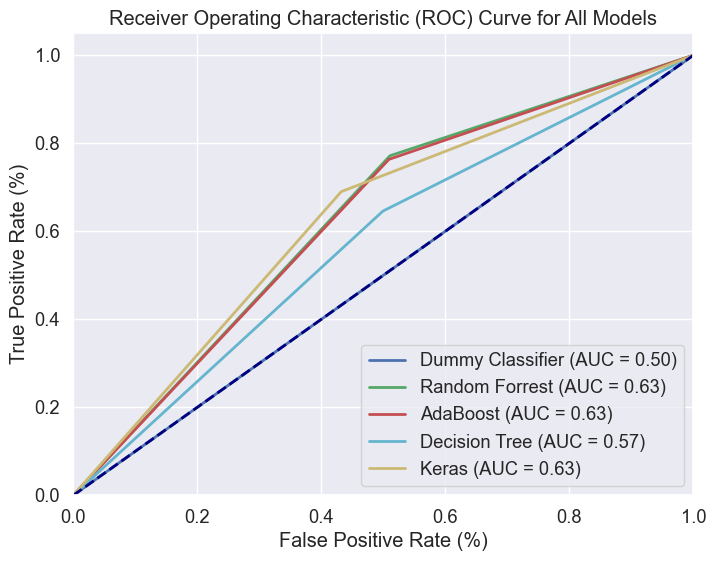

In [22]:
# Receiver Operating Characteristic (ROC) Curve

from sklearn.metrics import roc_curve, roc_auc_score

# Initialize lists to store ROC curve data and AUC scores for all models
fprs = []
tprs = []
aucs = []


# Calculate ROC curves and AUC scores for all models; "AUC" is "Area Under the ROC Curve"
for y_pred in model_predictions:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

# Create the ROC curve plot for all models
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'y']
for i in range(len(models)):
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=f'{models[i]} (AUC = {aucs[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (%)')
plt.ylabel('True Positive Rate (%)')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Models')
plt.legend(loc='lower right')
plt.show()

# An ROC curve is a graphical representation of a binary classification model's performance. It displays the trade-off 
# between the model's true positive rate (sensitivity) and false positive rate (1-specificity) as the classification 
# threshold is varied.

# A breakdown of heuristics regarding what the AUC ("Area Under the Curve") represents:

# AUC = 1.0: This is the ideal scenario, where the classifier has perfect performance. It means that for every threshold,
# the true positive rate is 1 and the false positive rate is 0.

# 0.5 < AUC < 1.0: The classifier does better than random guessing. The higher the AUC, the better the classifier is at 
# distinguishing between positive and negative classes.

# AUC = 0.5: The classifier performs no better than random guessing. The ROC curve will be a diagonal line from the bottom
# left to the top right. (See above for the low utility of plotting DummyClassifier results.)

# AUC < 0.5: The classifier performs worse than random guessing. However, in most practical scenarios, an AUC below 0.5 
# suggests that the labels have been inverted, and the classifier's decisions can be inverted to improve its performance.

## Tweak factors to increase the accuracy

In [63]:
# Reshow the Random Forest model that was used earlier

print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(y_test, predict_rf)}')

Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6847034339229969
Random Forest Recall: 0.7668997668997669


### 3 attempts at tweaking parameters for the model with the same features.

In [65]:
# Train, Test, Eval: Random Forest Classifier Model
# Changed n_estimators to 240, max_features to auto, min_samples_leaf and max_depth to 10
model_1 = RandomForestClassifier(n_estimators=240, max_features='sqrt', random_state=42, min_samples_leaf=10, max_depth=10)
model_1.fit(X_train, y_train)
predict_rf = model_1.predict(X_test)
acc_1 = accuracy_score(y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(y_test, predict_rf)}')

Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6749226006191951
Random Forest Recall: 0.7622377622377622


In [66]:
# Train, Test, Eval: Random Forest Classifier Model
# n_estimators to 280, max_features to auto, min_samples_leaf to 20 and max_depth to 10
model_2 = RandomForestClassifier(n_estimators=280, max_features='sqrt', random_state=42, min_samples_leaf=20, max_depth=10)
model_2.fit(X_train, y_train)
predict_rf = model_2.predict(X_test)
acc_2 = accuracy_score(y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(y_test, predict_rf)}')

Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6771894093686355
Random Forest Recall: 0.7750582750582751


In [67]:
# Train, Test, Eval: Random Forest Classifier Model
# n_estimators to 180, max_features back to 7, min_samples_leaf to 6 and max_depth to 10
model_3 = RandomForestClassifier(n_estimators=180, max_features=7, random_state=42, min_samples_leaf=6, max_depth=10)
model_3.fit(X_train, y_train)
predict_rf = model_3.predict(X_test)
acc_3 = accuracy_score(y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(y_test, predict_rf)}')

Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6837160751565762
Random Forest Recall: 0.7634032634032634


In [83]:
# Show feature importances
print(columns)
model_rf.feature_importances_


['R_odds', 'gender', 'lose_streak_dif', 'win_streak_dif', 'longest_win_streak_dif', 'win_dif', 'loss_dif', 'total_round_dif', 'ko_dif', 'sub_dif', 'height_dif', 'reach_dif', 'age_dif', 'avg_sub_att_dif', 'avg_td_dif']


array([0.46430852, 0.13592624, 0.10002243, 0.13314493, 0.16659788])

### 2 attempts at changing features. Adjusted parameters of model to push accuracy higher accordingly.

In [69]:
# Change features
# Select relevant columns. 
## Selected features where importance was above 0.03
new_columns = [
    'R_odds', 'win_dif', 'loss_dif', 'total_round_dif',
    'height_dif', 'reach_dif', 'age_dif',
    'avg_sub_att_dif', 'avg_td_dif'
]

new_X = ufcdata[new_columns]
# y is the same

# Split the dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, y, test_size=0.3, stratify=y, random_state=50 # Kept the same random state
)

In [70]:
# Train, Test, Eval: Random Forest Classifier Model

model_4 = RandomForestClassifier(n_estimators=130, max_features=7, random_state=42, min_samples_leaf=7, max_depth=10)
model_4.fit(new_X_train, new_y_train)
predict_rf = model_4.predict(new_X_test)
acc_4 = accuracy_score(new_y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(new_y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(new_y_test, predict_rf)}')

# Extract feature importances from the trained model
feature_importances = model_rf.feature_importances_

# Pair each feature name with its importance
features = list(new_X_train.columns)
feature_importance_pairs = list(zip(features, feature_importances))

# Sort feature importance pairs by importance in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print out the sorted feature importances
print("Feature Importances (Random Forest with Feature Set 2):")
for feature, importance in sorted_feature_importance_pairs:
    print(f"{feature}: {importance:.4f}")



Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6911764705882353
Random Forest Recall: 0.7668997668997669
Feature Importances (Random Forest with Feature Set 2):
R_odds: 0.4643
height_dif: 0.1666
win_dif: 0.1359
total_round_dif: 0.1331
loss_dif: 0.1000


In [71]:
# Change features
# Select relevant columns.
## Selected features where importance was above 0.06
new_columns = [
    'R_odds',  'total_round_dif',
    'age_dif',
    'avg_sub_att_dif', 'avg_td_dif'
]

new_X = ufcdata[new_columns]
# y is the same

# Split the dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, y, test_size=0.3, stratify=y, random_state=50 # Kept the same random state
)

In [72]:
# Train, Test, Eval: Random Forest Classifier Model
model_5 = RandomForestClassifier(n_estimators=180, max_features=5, random_state=42, min_samples_leaf=10, max_depth=10)
model_5.fit(new_X_train, new_y_train)
predict_rf = model_5.predict(new_X_test)
acc_5 = accuracy_score(new_y_test, predict_rf)
print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {precision_score(new_y_test, predict_rf)}')
print(f'Random Forest Recall: {recall_score(new_y_test, predict_rf)}')

Random Forest Accuracy: 0.6575901974132062
Random Forest Precision: 0.6847034339229969
Random Forest Recall: 0.7668997668997669


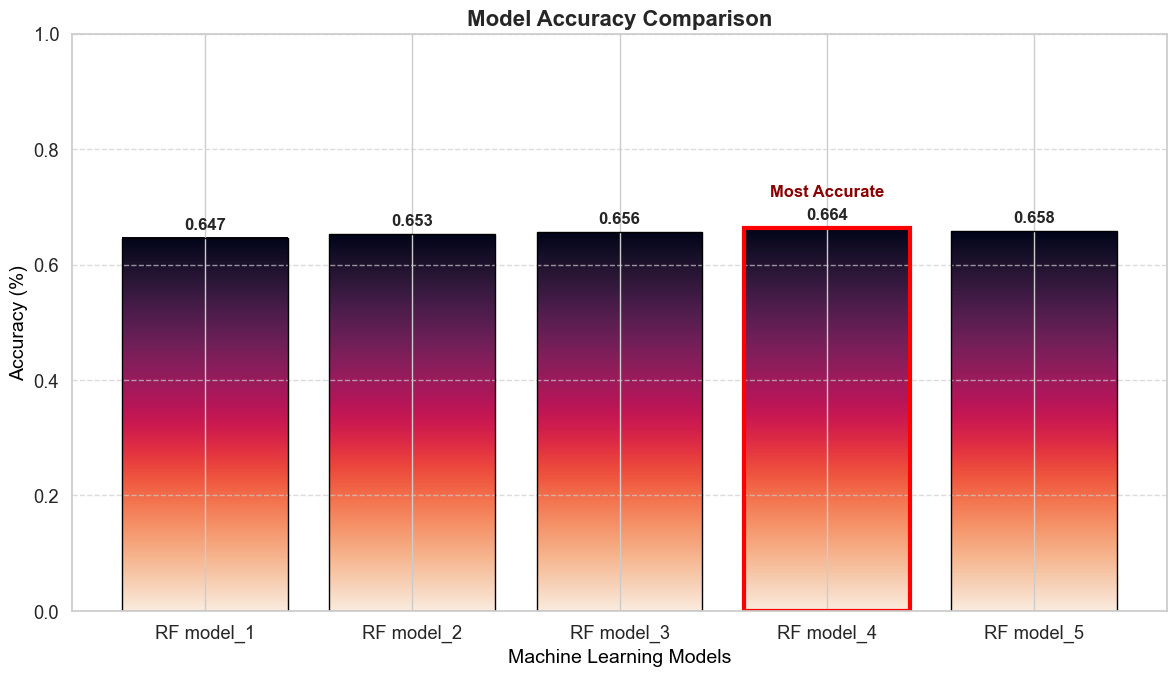

In [81]:
Mod_2 = ["RF model_1", "RF model_2", "RF model_3", "RF model_4", "RF model_5"]
accuracies_2 = [acc_1, acc_2, acc_3, acc_4, acc_5] 

def gradientbars(bars, highlight_index=None):
    grad = np.atleast_2d(np.linspace(0, 1, 256)).T
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for i, bar in enumerate(bars):
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0)
        if i == highlight_index:
            bar.set_edgecolor('red')
            bar.set_linewidth(3.0)
        else:
            bar.set_edgecolor('black')
            bar.set_linewidth(1.0)
    ax.axis(lim)

plt.figure(figsize=(12, 7))

# Define bars
bars = plt.bar(Mod_2, accuracies_2, color=custom_colors)

# Apply gradient to bars and highlight the bar with the highest accuracy
gradientbars(bars, highlight_index=max_index)

# Add title and labels
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Machine Learning Models', fontsize=14, color='black')  # Set axis label color to black
plt.ylabel('Accuracy (%)', fontsize=14, color='black')  # Set axis label color to black
plt.ylim(0, 1)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # If this bar represents the model with the highest accuracy, annotate it
    if idx == max_index:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, 'Most Accurate', ha='center', va='bottom', fontweight='bold', color='darkred', fontsize=12)

# Show the chart
plt.tight_layout()
plt.show()


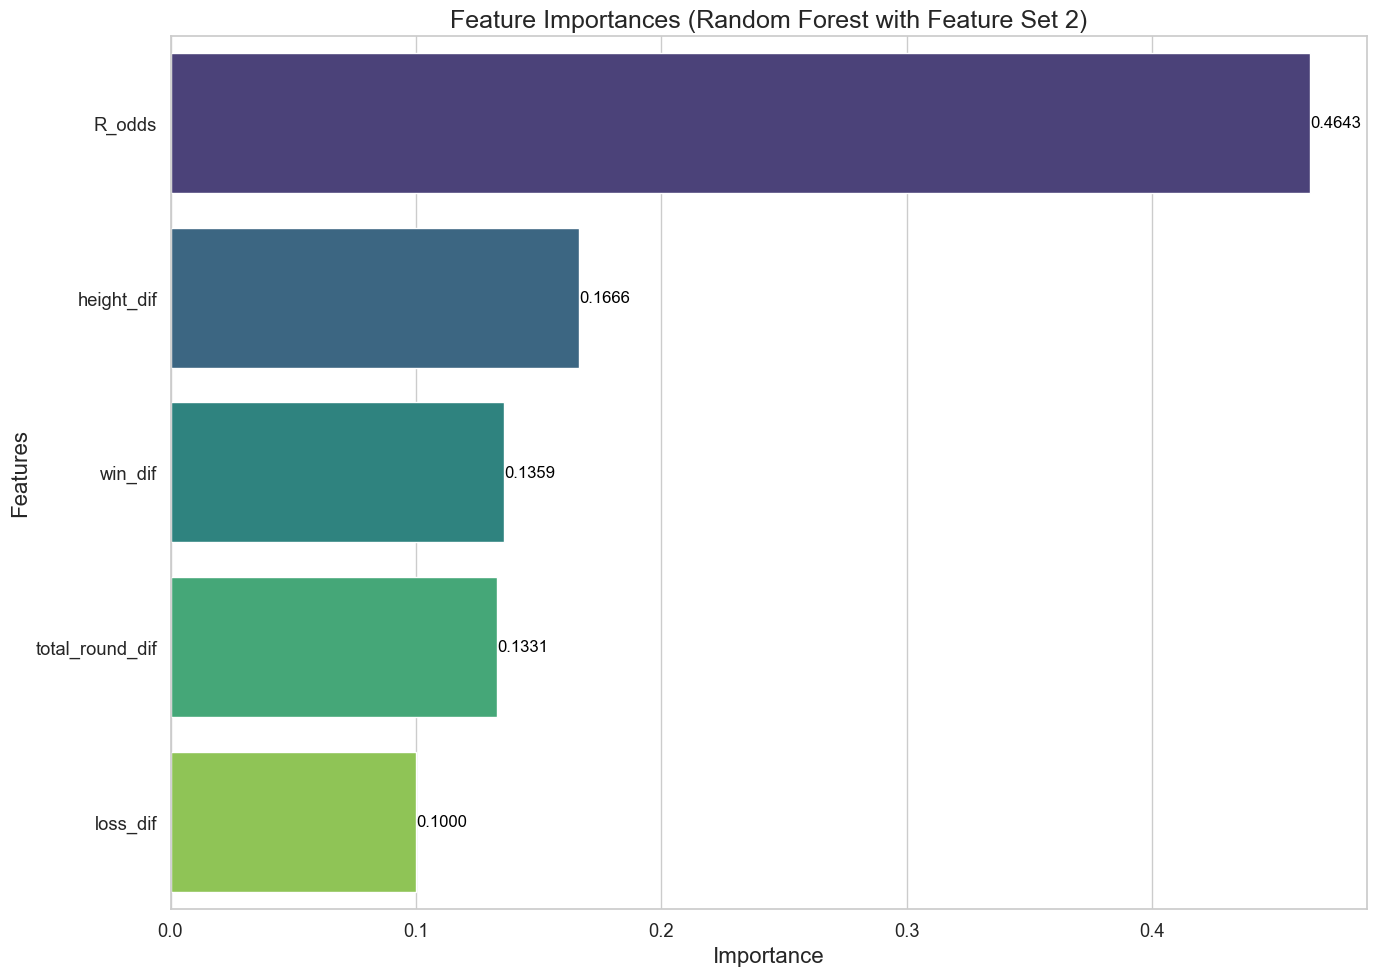

In [92]:
# Extracting the sorted feature names and their importances into two separate lists
sorted_features = [item[0] for item in sorted_feature_importance_pairs]
sorted_importances = [item[1] for item in sorted_feature_importance_pairs]

# Plotting the importances using Seaborn's barplot function
plt.figure(figsize=(14, 10))
ax = sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")

# Setting the title and labels
plt.title("Feature Importances (Random Forest with Feature Set 2)", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Features", fontsize=16)

# Adding numerical ticks on each bar for clarity
for index, value in enumerate(sorted_importances):
    ax.text(value, index, f'{value:.4f}', color='black', va="center", fontsize=12)

# Display the enhanced bar chart
plt.tight_layout()
plt.show()
